Building Classifier
--- You are a data scientist at vacation rental company. So far company was doing good differentiating itself as a company renting single family vacation homes only. Vocation season is about to start, customers renting, and homeowners are listing. Quality control team is overwhelmed. Team is asking is there way to make their life easier. Ypu just accepted the challenge of classifying listing automatically. As a proof of concept you start with 2 big classes residential, industrial. 

In [0]:
from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import os 
os.chdir('drive/My Drive/ClassifierProject')

In [7]:
!unzip staticmap


  inflating: __MACOSX/staticmap/train/residential/._35347716-94398326.jpg  
  inflating: staticmap/train/residential/394438031-768385402.jpg  
  inflating: __MACOSX/staticmap/train/residential/._394438031-768385402.jpg  
  inflating: staticmap/train/residential/396042859-119763301.jpg  
  inflating: __MACOSX/staticmap/train/residential/._396042859-119763301.jpg  
  inflating: staticmap/train/residential/395325153-757614732.jpg  
  inflating: __MACOSX/staticmap/train/residential/._395325153-757614732.jpg  
  inflating: staticmap/train/residential/414815481-730360772.jpg  
  inflating: __MACOSX/staticmap/train/residential/._414815481-730360772.jpg  
  inflating: staticmap/train/residential/416322204-937214358.jpg  
  inflating: __MACOSX/staticmap/train/residential/._416322204-937214358.jpg  
  inflating: staticmap/train/residential/415800724-938113353.jpg  
  inflating: __MACOSX/staticmap/train/residential/._415800724-938113353.jpg  
  inflating: staticmap/train/residential/411795929-87

In [12]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomRotation(359),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
total_data =  datasets.ImageFolder('staticmap', transform=transform)

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.15

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data =  datasets.ImageFolder('staticmap/train', transform=transform)
test_data =  datasets.ImageFolder('staticmap/test', transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)



Define Classes

In [0]:
# specify the image classes
classes = ['warehouse', 'residential']

In [15]:
len(train_idx)

1712

### Visualize a Batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

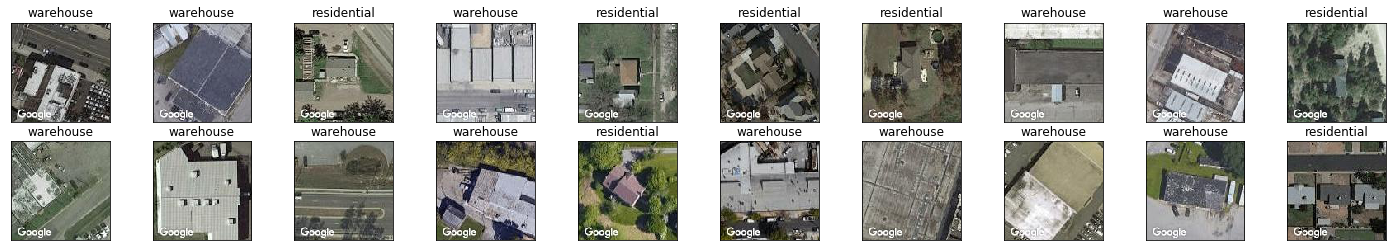

In [20]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
###Define pretrained model

In [0]:
 #Use GPU if it's available

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = models.densenet121(pretrained=True)

model = models.vgg16(pretrained=True)

Freez parameters

In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

Define model

In [0]:
model.classifier = nn.Sequential(nn.Linear(25088, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))
# model.classifier = nn.Sequential(nn.Linear(25088, 256),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(256, 2),
#                                  nn.LogSoftmax(dim=1))
# model.classifier = nn.Sequential(nn.Linear(25088, 256),
#                                  nn.Linear(256, 128),
#                                  nn.Linear(128, 64),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(64, 2),
#                                  nn.LogSoftmax(dim=1))

Define creterion and optimizer 

In [0]:
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen

In [0]:
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device);

In [257]:
import pandas as pd
epochs = 2
steps = 0
running_loss = 0
print_every = 5
train_stats = pd.DataFrame(columns = ['Epoch',  'Train loss',
                                      'Test loss'])
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {test_loss/len(valid_loader):.3f}.. "
                  f"Valid accuracy: {accuracy/len(valid_loader):.3f}")
            train_stats = train_stats.append({'Epoch': epoch, 
                                              'Train loss' : running_loss/print_every,
                                     'Valid loss' : test_loss/len(valid_loader)}, ignore_index=True)
            running_loss = 0
            model.train()

Epoch 1/2.. Train loss: 1.864.. Valid loss: 0.844.. Valid accuracy: 0.775
Epoch 1/2.. Train loss: 0.765.. Valid loss: 0.831.. Valid accuracy: 0.816
Epoch 1/2.. Train loss: 0.681.. Valid loss: 0.491.. Valid accuracy: 0.863
Epoch 1/2.. Train loss: 0.525.. Valid loss: 0.408.. Valid accuracy: 0.866
Epoch 1/2.. Train loss: 0.370.. Valid loss: 0.413.. Valid accuracy: 0.847
Epoch 1/2.. Train loss: 0.417.. Valid loss: 0.407.. Valid accuracy: 0.837
Epoch 1/2.. Train loss: 0.459.. Valid loss: 0.386.. Valid accuracy: 0.866
Epoch 1/2.. Train loss: 0.370.. Valid loss: 0.385.. Valid accuracy: 0.884
Epoch 1/2.. Train loss: 0.299.. Valid loss: 0.354.. Valid accuracy: 0.887
Epoch 1/2.. Train loss: 0.308.. Valid loss: 0.420.. Valid accuracy: 0.869
Epoch 1/2.. Train loss: 0.456.. Valid loss: 0.348.. Valid accuracy: 0.894
Epoch 1/2.. Train loss: 0.394.. Valid loss: 0.357.. Valid accuracy: 0.859
Epoch 1/2.. Train loss: 0.251.. Valid loss: 0.364.. Valid accuracy: 0.897
Epoch 1/2.. Train loss: 0.635.. Valid 

Visualize Loss History

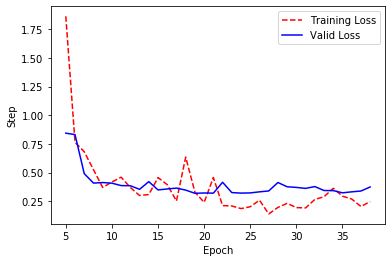

In [261]:
step_count = []
training_loss = []
valid_loss = []

for i in train_stats.iterrows():
    step_count.append(i[0] + 1 * 5)
    training_loss.append(i[1]['Train loss'])
    valid_loss.append(i[1]['Valid loss'])

plt.plot(step_count, training_loss, 'r--')
plt.plot(step_count, valid_loss, 'b-')
plt.legend(['Training Loss', 'Valid Loss'])
plt.xlabel('Epoch')
plt.ylabel('Step')
plt.show();

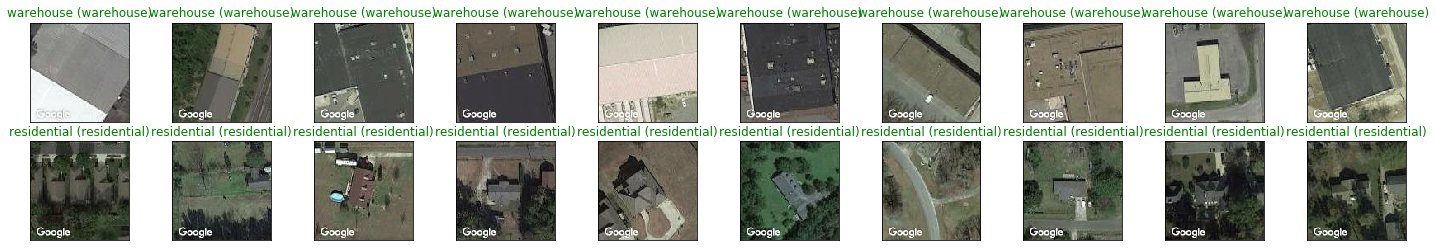

In [262]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))